<a href="https://colab.research.google.com/github/PeiYauWeng/MODQPSO_training_FNN/blob/main/GPU_accelerate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cupy as cp
class Mesh_Swarm(object):
  def __init__(self, num_particles, current_archiving_locations, current_archiving_fitness, num_mesh, maximum, minimum):
    self.current_archiving_locations = current_archiving_locations
    self.current_archiving_fitness = current_archiving_fitness
    self.num_mesh = num_mesh
    self.minimum = minimum
    self.maximum = maximum
    self.num_archiving_particles = self.current_archiving_locations.shape[0]
    self.num_particles = num_particles
    
    self.id_archiving_particles = cp.zeros((self.num_archiving_particles))
    self.gbest_parameters = cp.zeros((self.num_particles, self.current_archiving_locations.shape[1]))
    self.gbest_fitness = cp.zeros((self.num_particles, self.current_archiving_fitness.shape[1]))

  def get_crowd_archiving_particles(self):
    tmp = cp.multiply(self.num_mesh, cp.subtract(self.current_archiving_locations, self.minimum)) 
    distance = cp.subtract(self.maximum, self.minimum)
    self.id_archiving_particles = cp.divide(tmp, distance).astype(cp.int32)
    judge_table = self.id_archiving_particles[:,cp.newaxis,:] == self.id_archiving_particles
    judge_table = (cp.sum(judge_table, axis=2)==self.id_archiving_particles.shape[1])
    crowd_archiving_particles = cp.sum(judge_table, axis=1) 
    return crowd_archiving_particles

  def get_gbest(self):
    crowd_archiving_particles = self.get_crowd_archiving_particles()
    get_probability_chosen = cp.divide(1.0,(cp.power(crowd_archiving_particles,3)))
    get_probability_chosen = get_probability_chosen/cp.sum(get_probability_chosen)
    chosen_index = cp.multiply(get_probability_chosen, cp.random.uniform(0,1, (self.num_mesh,self.num_archiving_particles)))
    chosen_index = cp.sum(chosen_index, axis=0)
    chosen_index = cp.argsort(chosen_index)[cp.int32(self.num_archiving_particles*0.9)-1:]
    chosen_index = cp.random.choice(chosen_index,size=(self.num_particles),replace=True)
    self.gbest_parameters = self.current_archiving_locations[chosen_index]
    self.gbest_fitness = self.current_archiving_fitness[chosen_index]
    return self.gbest_parameters, self.gbest_fitness

  def pair_inner_outer_gbest(self):
    pair_table=cp.sum(cp.power(cp.subtract(self.gbest_parameters, self.gbest_parameters[:,cp.newaxis,:]), 2), axis=2)
    pair_table=cp.argmax(pair_table, axis=1)
    outer_gbest_parameters = self.gbest_parameters[pair_table]
    return outer_gbest_parameters
    
  def clear_archives(self,threshold):
    crowd_archiving_particles = self.get_crowd_archiving_particles()
    get_probability_chosen = crowd_archiving_particles/cp.sum(crowd_archiving_particles)
    rest_index = cp.multiply(get_probability_chosen, cp.random.uniform(0,1, (self.num_mesh,self.num_archiving_particles)))
    rest_index = cp.sum(rest_index, axis=0)
    rest_index = cp.argsort(rest_index)[:threshold]
    self.current_archiving_locations = self.current_archiving_locations[rest_index]
    self.current_archiving_fitness = self.current_archiving_fitness[rest_index]
    return self.current_archiving_locations, self.current_archiving_fitness

In [ ]:
class Pareto(object):
  def __init__(self, locations, fitness):
    self.locations = locations
    self.fitness = fitness
    self.dominant_value = len(self.fitness)-1
  
  def find_optimals(self):
    judge_table = self.fitness[:,cp.newaxis,:] < self.fitness
    delete_index = cp.sign(cp.sum(judge_table, axis=2))
    delete_index = cp.sum(delete_index, axis=1)
    self.fitness = self.fitness[cp.where(delete_index>=self.dominant_value)[0]]
    self.locations = self.locations[cp.where(delete_index>=self.dominant_value)[0]]
    return self.locations, self.fitness

In [ ]:
class MOQDPSO(object):
  '''num_particle: the number of particles
     dim_paricel: the dimesion of particles that correspond to the number of unoptimized parameters
     alpha: type of float. It is the contraction expansion coefficient and a positive number
     iterations: the number of iterstions
     maximum: type of float
     minimum: type of float'''
  def __init__(self, num_particles, dim_per_particle, num_objects, iterations, num_mesh, maximum, minimum, threshold, dtype):
    #define class parameters
    self.num_particles = num_particles
    self.dim_per_particle = dim_per_particle
    self.alpha = 1.0
    self.iterations = iterations
    self.maximum = maximum
    self.minimum = minimum
    self.num_mesh = num_mesh
    self.threshold = threshold
    self.dtype = dtype
    #initialize positions of swarm particles
    '''self.locations = cp.array(cp.random.uniform(self.minimum, 
                           self.maximum, 
                           size=(self.num_particles, self.dim_per_particle)),
                           dtype=self.dtype)'''
    self.locations = cp.empty(shape=(self.num_particles, self.dim_per_particle), dtype=self.dtype)
    self.pbest_parameters = cp.zeros(shape=(self.num_particles, self.dim_per_particle), dtype=self.dtype)
    self.fitness_values = cp.multiply(cp.inf, cp.ones(shape=(self.num_particles, num_objects), dtype=self.dtype))
    self.archiving_locations = self.locations
    self.archiving_fitness = cp.multiply(cp.inf, cp.ones(shape=(self.num_particles, num_objects), dtype=self.dtype))
    #self.archiving_fitness = cp.ones(shape=(self.num_particles, num_objects), dtype=self.dtype)
    self.gbest_parameters = cp.zeros(shape=(self.num_particles, self.dim_per_particle), dtype=self.dtype)
    self.outer_gbest_pair = cp.zeros(shape=(self.num_particles, self.dim_per_particle), dtype=self.dtype)

  '''QPSO initialize the first array of parameters.
     let users put in their model to run'''
  def get_particle_locations(self):
    return cp.asnumpy(self.locations)

  def input_new_locations(self, new_locations):
    #self.locations = cp.array(new_locations)
    self.locations = cp.asarray(new_locations, dtype=cp.float32)

  '''Co-learning method'''
  def co_learning_method(self, learning_rate):
    judge_table = cp.random.rand(self.num_particles,1)>learning_rate
    invert_table = cp.invert(judge_table)
    random_index = cp.random.choice(cp.arange(0,self.num_particles,1),size=(self.num_particles), replace=True)
    self_pair_table = (random_index==cp.arange(0,self.num_particles,1))
    random_index = cp.add(cp.multiply(random_index, cp.invert(self_pair_table)), 
                  cp.multiply(cp.multiply(random_index,self_pair_table),cp.random.rand(self.num_particles)).astype(cp.int32))
    random_index[0] = cp.add(cp.multiply(self_pair_table[0], cp.random.choice(cp.arange(0,self.num_particles,1),size=1)[0]),
                 cp.multiply(cp.invert(self_pair_table[0]), random_index[0]))
    dis_pbest2locations = cp.add(cp.multiply(cp.subtract(self.locations, self.pbest_parameters),judge_table),
                   cp.multiply(cp.subtract(self.locations, self.pbest_parameters[random_index]), invert_table))
    dis_pbest2locations = cp.abs(dis_pbest2locations)
    return dis_pbest2locations.astype(self.dtype)

  '''calculate fittness value
     input: self class object
           locations: the list of particles locations
           validation_scores: the 2D np array of validation score from the model
     output: fitness_value: the list of fitness_vlaue'''
  def fitness(self, validation_scores):
    #2D array validation scores
    current_fitness_values = cp.asarray(validation_scores, dtype=self.dtype)

    '''get current pbest parameters, archiving locations, archiving firness, gbest parameters and best fittness'''
    #update pbest_parameters and fitness_values(pbest fitness)
    judge_table = cp.sign(cp.subtract(current_fitness_values, self.fitness_values))
    t1=cp.where(cp.sum((judge_table == 1)+(judge_table == 0), axis=1)==3)
    t2=cp.where(cp.sum((judge_table == -1)+(judge_table == 0), axis=1)==3)
    random_index = cp.arange(0,self.num_particles,1)
    random_index[t1] = -1
    random_index[t2] = -1
    random_index = random_index[cp.where(random_index != -1)]
    #random_index = cp.delete(random_index, cp.hstack([cp.array(t1),cp.array(t2)]).flatten(), axis=0)
    if random_index.shape[0]>0:
      random_index = cp.random.choice(random_index, random_index.shape[0]//2, replace=False)
      self.fitness_values[random_index] = current_fitness_values[random_index]
      self.pbest_parameters[random_index] = self.locations[random_index]
    self.fitness_values[t2] = current_fitness_values[t2]
    self.pbest_parameters[t2] = self.locations[t2]

    #update archiving locations and archiving fitness
    pareto = Pareto(self.locations, current_fitness_values)
    optimal_locations, optimal_fitness = pareto.find_optimals()
    self.archiving_locations = cp.concatenate((self.archiving_locations, optimal_locations), axis=0)
    self.archiving_fitness = cp.concatenate((self.archiving_fitness, optimal_fitness), axis=0)
    pareto = Pareto(self.archiving_locations, self.archiving_fitness)
    self.archiving_locations, self.archiving_fitness = pareto.find_optimals()
    archiving = Mesh_Swarm(self.num_particles, self.archiving_locations, self.archiving_fitness, 
                 self.num_mesh, self.maximum, self.minimum)
    self.archiving_locations, self.archiving_fitness = archiving.clear_archives(self.threshold)
    #update gbest parameters
    archiving = Mesh_Swarm(self.num_particles, self.archiving_locations, self.archiving_fitness, 
                 self.num_mesh, self.maximum, self.minimum)
    self.gbest_parameters, gbest_fitness = archiving.get_gbest()
    self.outer_gbest_pair = archiving.pair_inner_outer_gbest()
    return gbest_fitness[cp.argmin(cp.mean(gbest_fitness, axis=1))]

  '''update particle positions
     input: self class object
     locations: the list of particles locations
     gbest_parameters: the list of global best parameters
     pbest_parameters: the list of the best position ever for every particle
     output: locations: the new list of particle positions'''
  def update(self, num_iteration):
    #calculate the distance between particle locations and mbest
    co_learning_rate = cp.power(cp.subtract(1, cp.power((num_iteration/self.iterations), 1/2)), 2)
    dis_co_pbest2locations = self.co_learning_method(co_learning_rate)

    #update random_point
    a = cp.random.uniform(0, 1, size=(self.num_particles,1)).astype(self.dtype)#covergence coefficient
    P1_pbest_parameters = cp.multiply(a, self.pbest_parameters)
    tmp = cp.multiply(cp.subtract(1,a), self.gbest_parameters)
    P1_pbest_parameters = cp.add(P1_pbest_parameters, tmp)
    a = cp.random.uniform(0, 1, size=(self.num_particles,1)).astype(self.dtype)#covergence coefficient
    P2_pbest_parameters = cp.multiply(a, self.pbest_parameters)
    tmp = cp.multiply(cp.subtract(1,a), self.outer_gbest_pair)
    P2_pbest_parameters = cp.add(P2_pbest_parameters, tmp)

    #update double contract expand coefficient: alpha, beta
    self.alpha = self.dtype(0.5*(self.iterations-num_iteration)/self.iterations + 0.5)
    tmp = cp.sign(cp.subtract(cp.random.uniform(0,1,size=(self.num_particles,1)), 0.5))
    self.alpha = cp.multiply(self.alpha, tmp)

    #update particle locations
    ln_one2u = cp.log(cp.divide(1, cp.random.uniform(size=(self.num_particles, 1))))
    tmp = cp.multiply(self.alpha, cp.multiply(ln_one2u, dis_co_pbest2locations))
    beta = cp.random.rand(self.num_particles, 1)
    self.locations = cp.multiply(1/2, cp.add(cp.add(P1_pbest_parameters, P2_pbest_parameters), 
                          cp.multiply(beta, cp.subtract(P1_pbest_parameters,P2_pbest_parameters))))
    #self.locations = np.add(tmp_pbest_parameters,tmp)
    #the paticle locations must be in [minimum, maximum] after updating
    tmp = cp.divide(cp.subtract(self.locations,cp.min(self.locations, axis=0)), 
                   cp.subtract(cp.max(self.locations, axis=0), cp.min(self.locations, axis=0)))
    self.locations = cp.add(cp.multiply(tmp,(self.maximum-self.minimum)), self.minimum)

In [ ]:
import numpy as np
class Node_deletion_rule(object):
  def __init__(self, model_shape, num_particle, locations):
    self.model_shape = np.array(model_shape)
    self.num_layers = len(model_shape) - 1
    self.num_particle = num_particle
    self.locations = locations
    self.num_connection = np.matmul(self.model_shape[np.newaxis,:-1], self.model_shape[np.newaxis,1:].T)[0,0]
    self.num_hidden_neurons = np.sum(model_shape[1:-1])
    self.smallest_bias = 0

  def trans_NN_weight(self, a_particle):
    flag=0
    record_layer_bias = list()
    record_layer_weight = list()
    total_bias = np.empty(0)
    for i in range(self.num_layers):
      layer_num_weight = self.model_shape[i]*self.model_shape[i+1]
      layer_num_bias = 1*self.model_shape[i+1]
      layer_weight = np.reshape(a_particle[flag:flag+layer_num_weight+layer_num_bias], newshape=(self.model_shape[i]+1,self.model_shape[i+1]))
      layer_bias, layer_weight = layer_weight[0], layer_weight[1:]
      total_bias = np.hstack((total_bias, layer_bias))
      #layer_bias = cp.array(layer_bias)
      #layer_weight = cp.array(layer_weight)
      record_layer_bias.append(layer_bias)
      record_layer_weight.append(layer_weight)
      flag += layer_num_weight+layer_num_bias
    self.smallest_bias = np.min(np.abs(total_bias))
    return record_layer_bias, record_layer_weight

  def rebuild_layer_weights(self, front_layer_weights, back_layer_weights):
    judge_table = self.smallest_bias <= np.abs(front_layer_weights)
    judge_table = np.sign(judge_table.sum(axis=0))
    judge_table2 = self.smallest_bias <= np.abs(back_layer_weights)
    judge_table2 = np.sign(judge_table2.sum(axis=1))
    judge_table = np.multiply(judge_table2, judge_table)
    deleted_neurons = np.sum(judge_table==0)
    front_layer_weights = np.multiply(front_layer_weights, judge_table)
    back_layer_weights = np.multiply(back_layer_weights, judge_table[:,np.newaxis])
    return front_layer_weights, back_layer_weights, deleted_neurons

  def execute_rule(self):
    ratio_active_connections = list()
    ratio_active_nodes = list()
    for i in range(self.num_particle):
      tmp_location = np.empty(0)
      total_deleted_neurons = 0
      num_inactive_connection = 0
      layers_bias, layers_weight = self.trans_NN_weight(self.locations[i])
      for j in range(self.num_layers-1):
        layers_weight[j], layers_weight[j+1], deleted_neurons = self.rebuild_layer_weights(layers_weight[j], layers_weight[j+1])
        total_deleted_neurons += deleted_neurons
      for k in range(self.num_layers):
        num_inactive_connection += np.sum(layers_weight[k]==0.0)
        tmp_location = np.hstack((tmp_location, np.hstack((layers_bias[k] , layers_weight[k].flatten()))))
      self.locations[i] = tmp_location
      ratio_active_connections.append((self.num_connection - num_inactive_connection)/self.num_connection)
      ratio_active_nodes.append((self.num_hidden_neurons - total_deleted_neurons)/self.num_hidden_neurons)
    return self.locations, np.array(ratio_active_connections), np.array(ratio_active_nodes)

In [ ]:
import matplotlib.pyplot as plt

def plot(results):
  # draw a diagram
  x = []
  y = []
  for i in range(len(results)):
    x.append(i + 1)
    y.append(results[i])
  plt.plot(x,y)
  plt.xlabel('Number of iteration',size = 15)
  plt.ylabel('Value of Fitnees',size = 15)
  plt.title('QDPSO_RBF_SVM parameter optimization')
  plt.show()

In [ ]:
from sklearn.datasets import load_iris

data = load_iris()
x = data.data
y = data.target
#print(y)
#x = cp.array(x)
#y = cp.array(y)
n_inputs = 4
n_hidden = 20
n_classes = 3
model_shape = [4, 20 ,3]

num_samples = 150

def logits_function(x, layers_bias, layers_weight):
  x = cp.asarray(x)
  z1 = cp.add(cp.dot(x,cp.asarray(layers_weight[0])), cp.asarray(layers_bias[0]))
  a1 = cp.tanh(z1)
  logits = cp.add(cp.dot(a1,cp.asarray(layers_weight[1])), cp.asarray(layers_bias[1]))
  return logits

def evaluation(y, logits, num_samples, ratio_active_connection, ratio_active_node):
  logprobs = cp.zeros(y.shape[0])
  exp_scores = cp.exp(logits)
  probs = exp_scores / cp.sum(exp_scores, axis=1, keepdims=True)
  for i in range(num_samples):
    logprobs[i] = probs[i,y[i]]
  logprobs = -cp.log(logprobs)
  loss = cp.divide(cp.sum(logprobs), num_samples)
  y_result = cp.argmax(logits, axis=1)
  y = cp.asarray(y)
  error = cp.subtract(1.0, cp.mean((y_result==y)))
  #print((y_result==y).mean())
  #MDL = error + ratio_active_connection
  ratio_active_connection = cp.asarray(ratio_active_connection)
  ratio_active_node = cp.asarray(ratio_active_node)
  fitting_value = cp.multiply(cp.power(ratio_active_connection,0.5),cp.power(ratio_active_node, 2))
  return cp.hstack((loss, error, fitting_value))

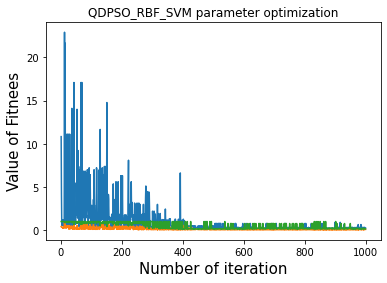

Training time:  144.6426968574524  seconds


In [ ]:
import time
n_inputs = 4
n_hidden = 20
n_classes = 3
model_shape = [4, 20 ,3]
num_samples = 150
num_particles = 50
dim_per_particle = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes 
num_ojects = 3
iterations = 1000
num_mesh = 10
threshold = 150
maximum = 30.0
minimum = -15.0
evaluation_threshold = [0.1, 0.02, 0.5]
storage=list()
#num_particles, dim_per_particle, num_objects, iterations, num_mesh, maximum, minimum, threshold, dtype)
particle_locations = np.random.uniform(minimum, 
                    maximum, 
                    size=(num_particles, dim_per_particle)).astype(cp.float32)
moqdpso = MOQDPSO(num_particles, dim_per_particle, num_ojects, iterations, num_mesh, maximum, minimum, threshold, cp.float32)
moqdpso.input_new_locations(particle_locations)
best_fitness_history=[]
evaluation_threshold = cp.array(evaluation_threshold)

start_time = time.time()
for i in range(iterations):
  score_storage=[]
  particle_locations = moqdpso.get_particle_locations()
  deletion = Node_deletion_rule(model_shape, num_particles, particle_locations)
  particle_locations, ratio_active_connections, ratio_active_nodes = deletion.execute_rule()
  moqdpso.input_new_locations(particle_locations)
  for j in range(num_particles):
    layer_bias, layer_weight = deletion.trans_NN_weight(particle_locations[j])
    model = logits_function(x, layer_bias, layer_weight)
    evaluation_val = evaluation(y, model, num_samples, ratio_active_connections[j], ratio_active_nodes[j])
    if (cp.sum(evaluation_val<=evaluation_threshold)==3):
      storage.append([evaluation_val, layer_bias, layer_weight])
    score_storage.append(evaluation_val)
  best_fitness = moqdpso.fitness(score_storage)
  best_fitness_history.append(best_fitness)
  moqdpso.update(i+1)
end_time = time.time()

plot(best_fitness_history)
print('Training time: ',(end_time-start_time),' seconds')

In [ ]:
best_fitness_history[950:]

[array([0.47006992, 0.33333334, 0.07247198], dtype=float32),
 array([0.27882504, 0.06666667, 0.76843345], dtype=float32),
 array([0.27882504, 0.06666667, 0.76843345], dtype=float32),
 array([0.43641534, 0.07333333, 0.4099634 ], dtype=float32),
 array([0.41867873, 0.11333334, 0.13584113], dtype=float32),
 array([0.28503978, 0.09333333, 0.2788548 ], dtype=float32),
 array([0.41867873, 0.11333334, 0.13584113], dtype=float32),
 array([0.2657942 , 0.12      , 0.76843345], dtype=float32),
 array([0.28503978, 0.09333333, 0.2788548 ], dtype=float32),
 array([0.41867873, 0.11333334, 0.13584113], dtype=float32),
 array([0.28503978, 0.09333333, 0.2788548 ], dtype=float32),
 array([0.10701049, 0.03333334, 1.        ], dtype=float32),
 array([0.74628866, 0.33333334, 0.01788854], dtype=float32),
 array([0.55192494, 0.33333334, 0.04929503], dtype=float32),
 array([0.74628866, 0.33333334, 0.01788854], dtype=float32),
 array([0.27882504, 0.06666667, 0.76843345], dtype=float32),
 array([0.74628866, 0.33